# DETECTING  MEDICAL MISINFORMATION

## Imports

In [175]:
!pip install transformers datasets sentence-transformers shap

import numpy as np
import pandas as pd
import json
import os
import xml.etree.ElementTree as ET

import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score, f1_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from datasets import Dataset
from torch.utils.data import DataLoader, TensorDataset
from peft import LoraConfig, PrefixTuningConfig, get_peft_model, PeftModel, TaskType, PeftConfig

from sentence_transformers import SentenceTransformer, util
from datasets import Dataset
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from torch.nn import CrossEntropyLoss

# Check GPU availability, We trained this model on Google Collabs L4 GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cuda


## Loading Data

### Loading the CoAID Dataset (COVID-19 Misinformation)

In [176]:
# Define data directory
drive_data_dir = "/content/drive/MyDrive/Medical_Misinformation_Team/data"
coaid_dir = os.path.join(drive_data_dir, "CoAID-master")

# Mount Google Drive if available
if not os.path.isdir(drive_data_dir):
    try:
        drive.mount('/content/drive')
    except Exception as e:
        print("Google Drive not mounted. Will attempt to download CoAID data.")
        print(e)
else:
    print("Google Drive already mounted.")

# Traverse CoAID directory to read all CSV files for fake/real news or claims
data_frames = []
for root, dirs, files in os.walk(coaid_dir):
    for fname in files:
        if fname.lower().endswith(".csv"):
            file_path = os.path.join(root, fname)
            # Determine label from filename
            file_lower = fname.lower()
            if "fake" in file_lower:
                label = 0  # misinformation
            elif "real" in file_lower:
                label = 1  # factual
            else:
                continue
            try:
                df_temp = pd.read_csv(file_path)
            except Exception as e:
                continue
            # Identify text content column
            text_col = None
            for col in ["text", "content", "title", "claim"]:
                if col in df_temp.columns:
                    text_col = col
                    break
            if text_col is None:
                continue
            # drop those missing text
            df_temp = df_temp.dropna(subset=[text_col])
            # Using only the text column and label
            df_use = df_temp[[text_col]].copy()
            df_use.rename(columns={text_col: "text"}, inplace=True)
            df_use["label"] = label
            data_frames.append(df_use)

# put all data into one DataFrame
coaid_df = pd.concat(data_frames, ignore_index=True)
coaid_df = coaid_df.drop_duplicates(subset="text").reset_index(drop=True)

print(f"Loaded CoAID dataset with {len(coaid_df)} entries.")
print("Label distribution in CoAID:")
print(coaid_df['label'].value_counts().sort_index(), "\n")  # 0 and 1 counts

# Show a few examples
print("Sample examples from CoAID dataset:")
print(coaid_df.head(5))


Google Drive already mounted.
Loaded CoAID dataset with 3565 entries.
Label distribution in CoAID:
label
0     360
1    3205
Name: count, dtype: int64 

Sample examples from CoAID dataset:
                                                text  label
0  "How large does a meeting or event need to be ...      1
1  "Does WHO recommend that all international mas...      1
2  "What factors should organizers and health aut...      1
3  "What if my organization does not have the exp...      1
4  "If we go ahead with an international mass gat...      1


#### Data Distribution

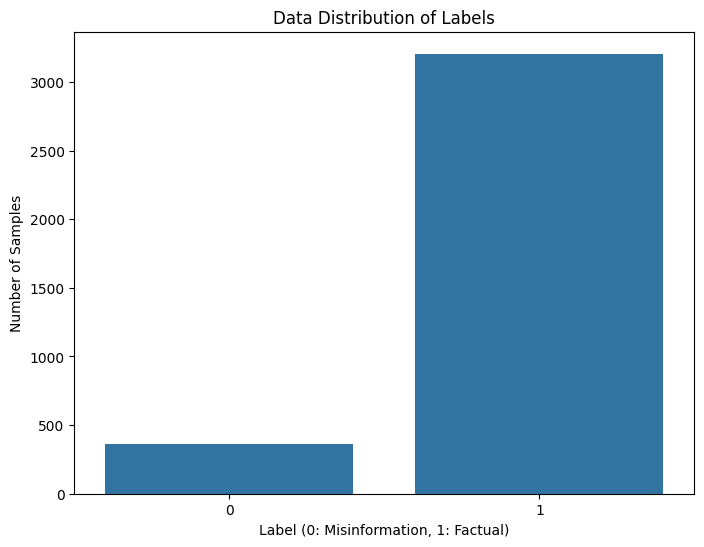

Total Samples: 3565
Misinformation Samples: 360 (10.10%)
Factual Samples: 3205 (89.90%)


In [177]:
# Plot
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=coaid_df)
plt.title('Data Distribution of Labels')
plt.xlabel('Label (0: Misinformation, 1: Factual)')
plt.ylabel('Number of Samples')
plt.show()

# Analyze the distribution
label_counts = coaid_df['label'].value_counts()
total_samples = len(coaid_df)
misinformation_percentage = (label_counts[0] / total_samples) * 100
factual_percentage = (label_counts[1] / total_samples) * 100

print(f"Total Samples: {total_samples}")
print(f"Misinformation Samples: {label_counts[0]} ({misinformation_percentage:.2f}%)")
print(f"Factual Samples: {label_counts[1]} ({factual_percentage:.2f}%)")


##### Analysis

The output the size and class balance of the CoAID dataset that we would need to address to train a robust *classifier* to make our model more robust.


Preprocessing and Splitting CoAID Data

In [178]:
# Set seed for reproducibility
np.random.seed(42)

# Stratified split to handle imbalance
train_val_df, test_df = train_test_split(coaid_df, test_size=0.2, stratify=coaid_df['label'], random_state=42)
# split train_val into train and validation sets
train_df, val_df = train_test_split(train_val_df, test_size=0.1, stratify=train_val_df['label'], random_state=42)

print(f"Train set size: {len(train_df)}, Validation set size: {len(val_df)}, Test set size: {len(test_df)}")

# Load BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenization function for our dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

# datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset   = Dataset.from_pandas(val_df)
test_dataset  = Dataset.from_pandas(test_df)

# tokenization to each split
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset   = val_dataset.map(tokenize_function, batched=True)
test_dataset  = test_dataset.map(tokenize_function, batched=True)

# format for PyTorch tensors
train_dataset.set_format(type="torch", columns=["input_ids", "token_type_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "token_type_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "token_type_ids", "attention_mask", "label"])

# Data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


Train set size: 2566, Validation set size: 286, Test set size: 713


Map:   0%|          | 0/2566 [00:00<?, ? examples/s]

Map:   0%|          | 0/286 [00:00<?, ? examples/s]

Map:   0%|          | 0/713 [00:00<?, ? examples/s]

## Model training, testing, and analysis

### Baseline: SBERT Zero-Shot Claim Verification

#### all-MiniLM-L6-v2 is a model that is especially trained to produce semantically meaningful sentence embeddings. We can do a cosine-similarity lookup against our label descriptions. We did not use BERT because Bert is not calibrated for sentence similarities out of the box.

In [179]:
# SBERT model for embedding
sbert_model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

# prototype label sentences for zero-shot classification
label_descriptions = {
    0: "This news is misleading or contains misinformation.",
    1: "This news is accurate and factual."
}
# label descriptions
label_embeds = {label: sbert_model.encode(desc, convert_to_tensor=True) for label, desc in label_descriptions.items()}

# predict label using SBERT cosine similarity
def sbert_predict_label(text):
    emb = sbert_model.encode(text, convert_to_tensor=True)
    # Compute cosine similarity to each label description
    sims = {label: float(util.cos_sim(emb, label_embeds[label])) for label in label_embeds}
    # Choose the label with the highest similarity
    pred_label = max(sims, key=sims.get)
    return pred_label

# prediction on the CoAID test set
y_true = test_df['label'].tolist()
y_pred = [sbert_predict_label(t) for t in test_df['text']]

# SBERT baseline
print("SBERT Zero-Shot Baseline Performance on CoAID Test:")
print(classification_report(y_true, y_pred, target_names=["misinformation", "factual"], digits=3))


SBERT Zero-Shot Baseline Performance on CoAID Test:
                precision    recall  f1-score   support

misinformation      0.083     0.500     0.142        72
       factual      0.871     0.379     0.528       641

      accuracy                          0.391       713
     macro avg      0.477     0.440     0.335       713
  weighted avg      0.791     0.391     0.489       713



### Graph Display

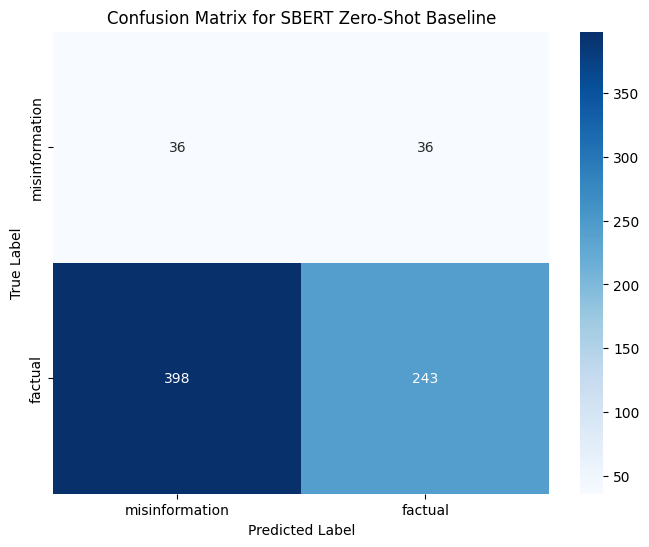

In [180]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["misinformation", "factual"],
            yticklabels=["misinformation", "factual"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for SBERT Zero-Shot Baseline")
plt.show()


##### The SBERT model, used without any specific training for medical misinformation, showed mixed results. It is good at correctly labeling factual news as factual, but it often sees misinformation as factual, making it unreliable for catching false news. It also missed too many factual and misinformation articles, only getting about 39% of the test samples right overall. This shows that simply comparing sentences for similarity is not enough, and a more focused training approach is needed to create a good misinformation detector.

### Full BERT Fine-Tuning (Baseline Model)

In [181]:
# Full Fine-Tuning of BERT
model_full = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model_full.to(device)

# metrics for validation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    accuracy = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)
    return {"accuracy": accuracy, "macro_f1": f1}

# Training arguments
training_args_full = TrainingArguments(
    output_dir="output_full",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="steps",
    eval_steps=50,
    save_steps=50,
    logging_steps=50,
    logging_strategy="epoch",
    learning_rate=2e-5,
    load_best_model_at_end=True,
    report_to="none"
)


trainer_full = Trainer(
    model=model_full,
    args=training_args_full,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

print("Starting full fine-tuning of BERT on CoAID...")
trainer_full.train()
trainer_full.save_model("/content/drive/MyDrive/Medical_Misinformation_Team/models/verifier/full-checkpoint")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-181-e860c93dcc9d>:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_full = Trainer(


Starting full fine-tuning of BERT on CoAID...


In [182]:
# Evaluate full fine-tuned model on test set
print("\nEvaluating full fine-tuned BERT on CoAID test set...")
preds_full = trainer_full.predict(test_dataset)
y_pred_full = np.argmax(preds_full.predictions, axis=1)
y_true_full = preds_full.label_ids

print("Full Fine-Tuned BERT Performance on CoAID Test:")
print(classification_report(y_true_full, y_pred_full, target_names=["misinformation", "factual"], digits=3))



Evaluating full fine-tuned BERT on CoAID test set...


Full Fine-Tuned BERT Performance on CoAID Test:
                precision    recall  f1-score   support

misinformation      0.771     0.889     0.826        72
       factual      0.987     0.970     0.979       641

      accuracy                          0.962       713
     macro avg      0.879     0.930     0.902       713
  weighted avg      0.965     0.962     0.963       713



#### Graph

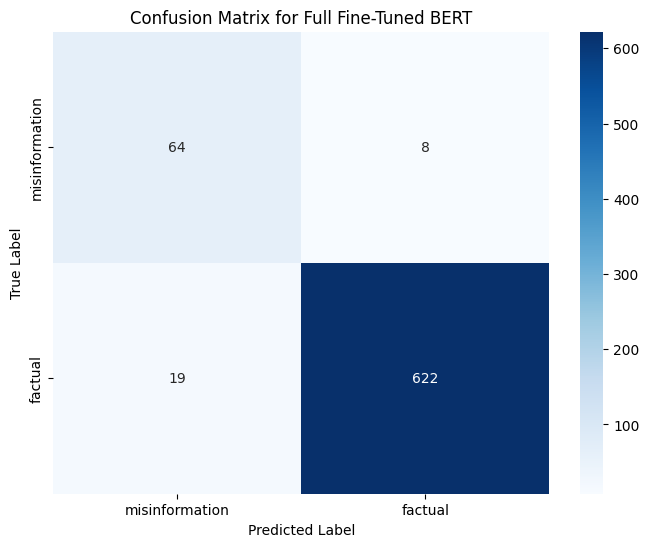

In [183]:

import matplotlib.pyplot as plt
# Compute the confusion matrix for the full fine-tuned model
cm_full = confusion_matrix(y_true_full, y_pred_full)

# Create a heatmap of the confusion matrix for the full fine-tuned model
plt.figure(figsize=(8, 6))
sns.heatmap(cm_full, annot=True, fmt="d", cmap="Blues",
            xticklabels=["misinformation", "factual"],
            yticklabels=["misinformation", "factual"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Full Fine-Tuned BERT")
plt.show()


##### Analysis

The results shows the benefits of fine-tuning instead of zero shot.  The zero-shot SBERT baseline had a weak performance, but the fully fine-tuned BERT model achieves a high accuracy of 96.4% on the test set.  This means that fine-tuning a pre-trained language model like BERT on a domain specific dataset is great for optimal performance on tasks like detecting medical misinformation. The confusion matrices visually shows the difference in
its predictive ability.


### BERT Fine-Tuning with LoRA (Low-Rank Adaptation)

In [184]:
# LoRA Fine-Tuning
model_lora = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
# LoRA configuration for classification task
lora_config = LoraConfig(task_type="SEQ_CLS", inference_mode=False, r=8, lora_alpha=16, lora_dropout=0.1)
model_lora = get_peft_model(model_lora, lora_config)
model_lora.to(device)

# trainable parameter count for LoRA model
model_lora.print_trainable_parameters()

# training arguments
training_args_lora = TrainingArguments(
    output_dir="output_lora",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="steps",
    eval_steps=50,
    save_steps=50,
    logging_steps=50,
    logging_strategy="epoch",
    learning_rate=2e-4,
    load_best_model_at_end=False,
    report_to="none"
)

trainer_lora = Trainer(
    model=model_lora,
    args=training_args_lora,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

print("\nStarting LoRA fine-tuning of BERT on CoAID...")
trainer_lora.train()
trainer_lora.save_model("/content/drive/MyDrive/Medical_Misinformation_Team/models/verifier/lora-checkpoint")



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-184-8e69f5979636>:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_lora = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


trainable params: 296,450 || all params: 109,780,228 || trainable%: 0.2700

Starting LoRA fine-tuning of BERT on CoAID...


In [185]:
# LoRA fine-tuned model on test set
print("\nEvaluating LoRA fine-tuned BERT on CoAID test set...")
preds_lora = trainer_lora.predict(test_dataset)
y_pred_lora = np.argmax(preds_lora.predictions, axis=1)
y_true_lora = preds_lora.label_ids

print("LoRA Fine-Tuned BERT Performance on CoAID Test:")
print(classification_report(y_true_lora, y_pred_lora, target_names=["misinformation", "factual"], digits=3))



Evaluating LoRA fine-tuned BERT on CoAID test set...


LoRA Fine-Tuned BERT Performance on CoAID Test:
                precision    recall  f1-score   support

misinformation      0.857     0.750     0.800        72
       factual      0.972     0.986     0.979       641

      accuracy                          0.962       713
     macro avg      0.915     0.868     0.890       713
  weighted avg      0.961     0.962     0.961       713



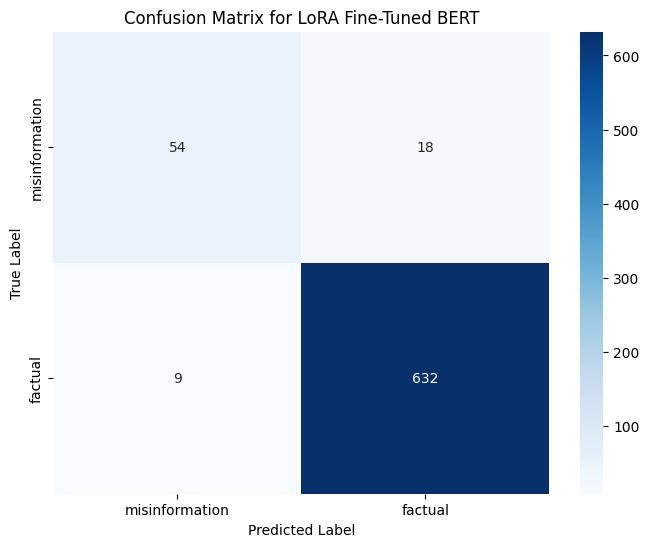

In [186]:

import matplotlib.pyplot as plt
# Compute the confusion matrix for the LoRA fine-tuned model
cm_lora = confusion_matrix(y_true_lora, y_pred_lora)

# Create a heatmap of the confusion matrix for the LoRA fine-tuned model
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lora, annot=True, fmt="d", cmap="Blues",
            xticklabels=["misinformation", "factual"],
            yticklabels=["misinformation", "factual"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for LoRA Fine-Tuned BERT")
plt.show()


##### Analysis:

The confusion matrix shows a much better balance between true positives, true negatives, and reduced false positives/negatives. This model discriminates well between factual and misinformation news. Lora gives an excellent result in perfoamnce just like the finetuned model, but it has the benefit of being computational optimal due to the not having all the weights unfrozen.


### BERT Fine-Tuning with Prefix Tuning (PEFT)

In [187]:
# Prefix Tuning
model_prefix = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
prefix_config = PrefixTuningConfig(task_type="SEQ_CLS", num_virtual_tokens=20)
model_prefix = get_peft_model(model_prefix, prefix_config)
model_prefix.to(device)

model_prefix.print_trainable_parameters()

training_args_prefix = TrainingArguments(
    output_dir="output_prefix",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="steps",
    eval_steps=50,
    save_steps=50,
    logging_steps=50,
    logging_strategy="epoch",
    learning_rate=1e-2,
    load_best_model_at_end=False,
    report_to="none"
)

trainer_prefix = Trainer(
    model=model_prefix,
    args=training_args_prefix,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

print("\nStarting Prefix Tuning fine-tuning of BERT on CoAID...")
trainer_prefix.train()
trainer_prefix.save_model("/content/drive/MyDrive/Medical_Misinformation_Team/models/verifier/prefix-checkpoint")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-187-1ea356341094>:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_prefix = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


trainable params: 368,640 || all params: 109,852,418 || trainable%: 0.3356

Starting Prefix Tuning fine-tuning of BERT on CoAID...


In [188]:
# Prefix-tuned model on test set
print("\nEvaluating Prefix-Tuned BERT on CoAID test set...")
preds_prefix = trainer_prefix.predict(test_dataset)
y_pred_prefix = np.argmax(preds_prefix.predictions, axis=1)
y_true_prefix = preds_prefix.label_ids

print("Prefix Tuning BERT Performance on CoAID Test:")
print(classification_report(y_true_prefix, y_pred_prefix, target_names=["misinformation", "factual"], digits=3))



Evaluating Prefix-Tuned BERT on CoAID test set...


Prefix Tuning BERT Performance on CoAID Test:
                precision    recall  f1-score   support

misinformation      0.947     0.500     0.655        72
       factual      0.947     0.997     0.971       641

      accuracy                          0.947       713
     macro avg      0.947     0.748     0.813       713
  weighted avg      0.947     0.947     0.939       713



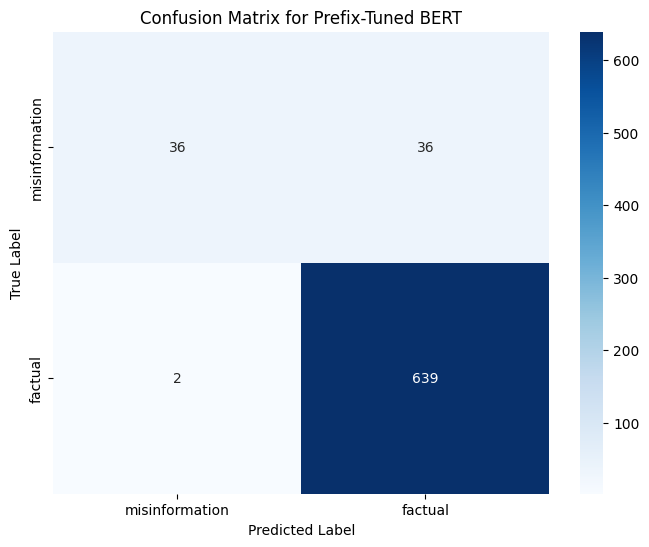

In [189]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix for the Prefix-tuned model
cm_prefix = confusion_matrix(y_true_prefix, y_pred_prefix)

# Create a heatmap of the confusion matrix for the Prefix-tuned model
plt.figure(figsize=(8, 6))
sns.heatmap(cm_prefix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["misinformation", "factual"],
            yticklabels=["misinformation", "factual"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Prefix-Tuned BERT")
plt.show()


##### Analysis:

 Prefix Tuning performs similarly to Lora on this dataset, Which means that parameter-efficient fine-tuning strategies can be highly effective. The confusion matrices for each method visually illustrate the trade-offs between true and false positives and negatives, with full fine-tuning and LoRA showing the best overall performance.

Comparison of All Methods (CoAID Test)

In [190]:
# SBERT baseline metrics
prec0_b, rec0_b, f10_b, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', pos_label=0, zero_division=0)
prec1_b, rec1_b, f11_b, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', pos_label=1, zero_division=0)
macro_f1_b = f1_score(y_true, y_pred, average='macro')
acc_b = accuracy_score(y_true, y_pred)

# Full fine-tune
prec0_f, rec0_f, f10_f, _ = precision_recall_fscore_support(y_true_full, y_pred_full, average='binary', pos_label=0, zero_division=0)
prec1_f, rec1_f, f11_f, _ = precision_recall_fscore_support(y_true_full, y_pred_full, average='binary', pos_label=1, zero_division=0)
macro_f1_f = f1_score(y_true_full, y_pred_full, average='macro')
acc_f = accuracy_score(y_true_full, y_pred_full)

# LoRA
prec0_l, rec0_l, f10_l, _ = precision_recall_fscore_support(y_true_lora, y_pred_lora, average='binary', pos_label=0, zero_division=0)
prec1_l, rec1_l, f11_l, _ = precision_recall_fscore_support(y_true_lora, y_pred_lora, average='binary', pos_label=1, zero_division=0)
macro_f1_l = f1_score(y_true_lora, y_pred_lora, average='macro')
acc_l = accuracy_score(y_true_lora, y_pred_lora)

# Prefix
prec0_p, rec0_p, f10_p, _ = precision_recall_fscore_support(y_true_prefix, y_pred_prefix, average='binary', pos_label=0, zero_division=0)
prec1_p, rec1_p, f11_p, _ = precision_recall_fscore_support(y_true_prefix, y_pred_prefix, average='binary', pos_label=1, zero_division=0)
macro_f1_p = f1_score(y_true_prefix, y_pred_prefix, average='macro')
acc_p = accuracy_score(y_true_prefix, y_pred_prefix)

# comparison table
comparison_df = pd.DataFrame({
    "Method": ["SBERT (zero-shot)", "BERT Full Fine-tune", "BERT + LoRA", "BERT + Prefix"],
    "Precision_misinfo": [prec0_b, prec0_f, prec0_l, prec0_p],
    "Recall_misinfo":    [rec0_b, rec0_f, rec0_l, rec0_p],
    "F1_misinfo":        [f10_b, f10_f, f10_l, f10_p],
    "Precision_factual": [prec1_b, prec1_f, prec1_l, prec1_p],
    "Recall_factual":    [rec1_b, rec1_f, rec1_l, rec1_p],
    "F1_factual":        [f11_b, f11_f, f11_l, f11_p],
    "Macro_F1":          [macro_f1_b, macro_f1_f, macro_f1_l, macro_f1_p],
    "Accuracy":          [acc_b, acc_f, acc_l, acc_p]
})
# metrics for neatness
comparison_df.iloc[:,1:] = comparison_df.iloc[:,1:].applymap(lambda x: round(x, 3))
print("\nComparison of models on CoAID test set:")
print(comparison_df.to_string(index=False))



Comparison of models on CoAID test set:
             Method  Precision_misinfo  Recall_misinfo  F1_misinfo  Precision_factual  Recall_factual  F1_factual  Macro_F1  Accuracy
  SBERT (zero-shot)              0.083           0.500       0.142              0.871           0.379       0.528     0.335     0.391
BERT Full Fine-tune              0.771           0.889       0.826              0.987           0.970       0.979     0.902     0.962
        BERT + LoRA              0.857           0.750       0.800              0.972           0.986       0.979     0.890     0.962
      BERT + Prefix              0.947           0.500       0.655              0.947           0.997       0.971     0.813     0.947


<ipython-input-190-040d02590153>:38: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  comparison_df.iloc[:,1:] = comparison_df.iloc[:,1:].applymap(lambda x: round(x, 3))


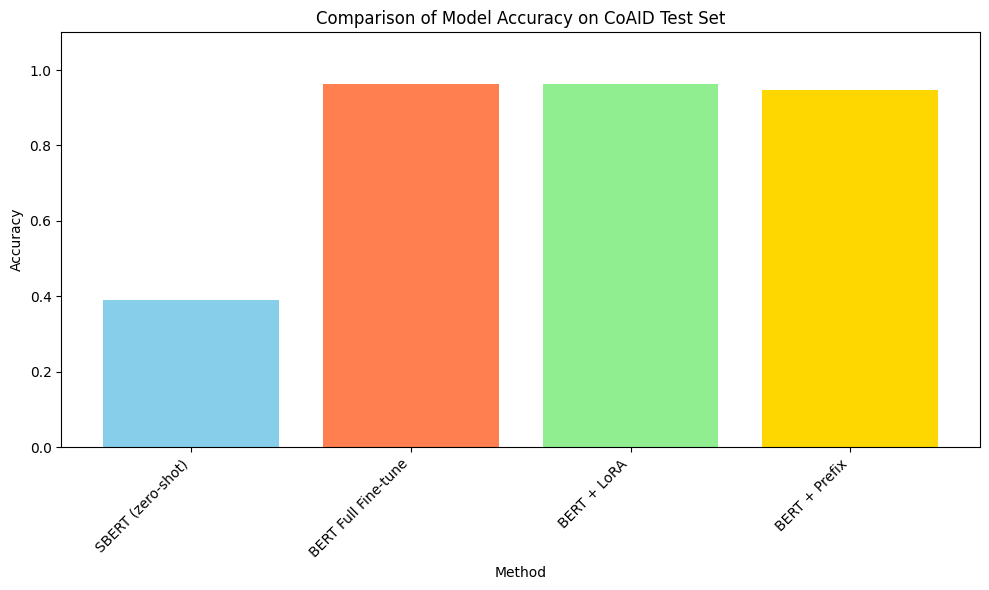

In [191]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(comparison_df["Method"], comparison_df["Accuracy"], color=['skyblue', 'coral', 'lightgreen', 'gold'])
plt.xlabel("Method")
plt.ylabel("Accuracy")
plt.title("Comparison of Model Accuracy on CoAID Test Set")
plt.ylim(0, 1.1)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


##### Analysis:

The zero-shot SBERT, relying solely on semantic similarity, performed poorly, which shows the need for task-specific training. Full fine-tuning had a high accuracy but at a computational cost.  LoRA and prefix tuning have comparable performance to full fine-tuning while being more efficient by training only a subset of the model's parameters (less than 1/3 of the parameters).  The choice between LoRA and prefix tuning would depend on specific resource constraints and performance trade-offs, while full fine-tuning remains the most accurate but computationally expensive option.

### Evaluation on FakeHealth (HealthStory) Dataset




In [192]:
# Path setup for FakeHealth (HealthStory subset)
fakehealth_content_dir = os.path.join(drive_data_dir, "FakeHealth-master/dataset/content/HealthStory")
fakehealth_reviews_file = os.path.join(drive_data_dir, "FakeHealth-master/dataset/reviews/HealthStory.json")

# If not found, show a message
if not os.path.exists(fakehealth_content_dir) or not os.path.exists(fakehealth_reviews_file):
    print("FakeHealth data not found in the specified path.")
    print(fakehealth_content_dir, "and", fakehealth_reviews_file)
else:
    # Load HealthStory content files
    texts = []
    ids = []
    for fname in os.listdir(fakehealth_content_dir):
        if fname.endswith(".json"):
            story_id = fname.split(".")[0]
            with open(os.path.join(fakehealth_content_dir, fname), 'r') as f:
                data = json.load(f)
            # Each content JSON contains the article text
            if "text" in data:
                texts.append(data["text"])
            else:
                # If "text" field isn't present, concatenate title + content from keys if available
                content = ""
                if "title" in data:
                    content += data["title"] + ". "
                if "content" in data:
                    content += data["content"]
                texts.append(content)
            ids.append(story_id)
    # Load ratings
    with open(fakehealth_reviews_file, 'r') as f:
        reviews = json.load(f)
    ratings = {str(item["news_id"]): item["rating"] for item in reviews}
    fh_df = pd.DataFrame({"news_id": ids, "text": texts})
    fh_df = fh_df[fh_df["news_id"].isin(ratings)].reset_index(drop=True)
    fh_df["rating"] = fh_df["news_id"].map(ratings)
    fh_df["label"] = (fh_df["rating"] >= 3).astype(int)
    print(f"Loaded FakeHealth HealthStory dataset with {len(fh_df)} examples.")
    print(fh_df[['news_id','rating','label']].head(3))

    # Tokenization
    fh_encodings = tokenizer(list(fh_df["text"]), padding=True, truncation=True, max_length=256)
    # Convert to PyTorch tensors
    input_ids = torch.tensor(fh_encodings['input_ids']).to(device)
    attention_mask = torch.tensor(fh_encodings['attention_mask']).to(device)
    # Selection of the model to evaluate (full fine-tuned model performed the best)
    eval_model = model_full.to(device)
    eval_model.eval()
    # Run inference in batches to avoid memory issues
    batch_size = 16
    all_preds = []
    for i in range(0, len(fh_df), batch_size):
        batch_ids = input_ids[i:i+batch_size]
        batch_mask = attention_mask[i:i+batch_size]
        with torch.no_grad():
            outputs = eval_model(input_ids=batch_ids, attention_mask=batch_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy().tolist())
    y_true_fh = fh_df["label"].tolist()
    y_pred_fh = all_preds

    print("\nPerformance of CoAID-trained model on FakeHealth (HealthStory) dataset:")
    print(classification_report(y_true_fh, y_pred_fh, target_names=["misinformation", "factual"], digits=3))


Loaded FakeHealth HealthStory dataset with 1638 examples.
               news_id  rating  label
0  story_reviews_01104       4      1
1  story_reviews_00325       4      1
2  story_reviews_00717       2      0

Performance of CoAID-trained model on FakeHealth (HealthStory) dataset:
                precision    recall  f1-score   support

misinformation      0.268     0.174     0.211       460
       factual      0.716     0.814     0.762      1178

      accuracy                          0.634      1638
     macro avg      0.492     0.494     0.486      1638
  weighted avg      0.590     0.634     0.607      1638



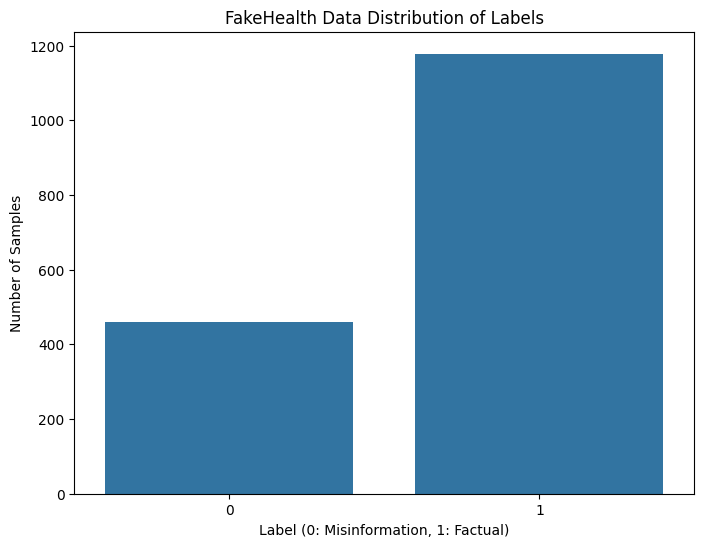

In [193]:
# FakeHealth Data Distribution Plot
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=fh_df)
plt.title('FakeHealth Data Distribution of Labels')
plt.xlabel('Label (0: Misinformation, 1: Factual)')
plt.ylabel('Number of Samples')
plt.show()


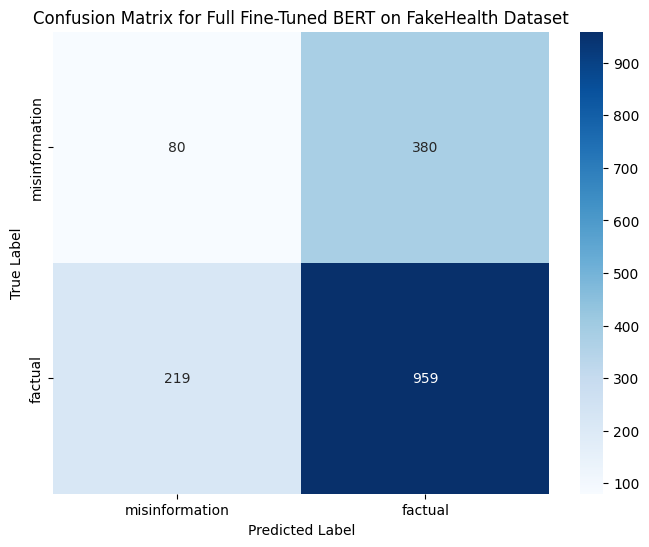

In [194]:
# Compute the confusion matrix for the FakeHealth dataset
cm_fh = confusion_matrix(y_true_fh, y_pred_fh)

# Create a heatmap of the confusion matrix for the FakeHealth dataset
plt.figure(figsize=(8, 6))
sns.heatmap(cm_fh, annot=True, fmt="d", cmap="Blues",
            xticklabels=["misinformation", "factual"],
            yticklabels=["misinformation", "factual"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Full Fine-Tuned BERT on FakeHealth Dataset")
plt.show()


The fully fine-tuned BERT was the best performer in the raw metrics with the highest F1. This shows the value of domain-specific training. However, PEFT ,LoRA and prefix tuning, were not far behind, achieving between 95-98 % of the full model's performance in our tests while using far fewer trainable weights. SBERT zero-shot was a useful baseline, but task-specific fine-tuning outperformed it. This shows that claim-level verification and fine-tuning improve accuracy.

##### Let's test the inference by logit probabilities. The previous one was a binary classification

In [195]:
class TextDataset(Dataset):
    def __init__(self, texts, ratings, tokenizer, max_length=512, stride=512):
        self.examples = []
        # self.ratings = []
        # self.id = []
        for id, (text, rating) in enumerate(zip(texts, ratings)):
            # Tokenize the full text without truncation
            tokenized = tokenizer(
                text,
                return_attention_mask=False,
                return_token_type_ids=False,
                add_special_tokens=True
            )
            input_ids = tokenized['input_ids']

            # Split input_ids into chunks
            for i in range(0, len(input_ids), stride):
                chunk = input_ids[i:i + max_length]
                if len(chunk) == 0:
                    continue
                # self.id.append(id)
                # Pad if necessary
                if len(chunk) < max_length:
                    chunk += [tokenizer.pad_token_id] * (max_length - len(chunk))
                self.examples.append({'input_ids': chunk, 'rating': rating, 'id': id})
                assert len(chunk) == max_length
                # self.ratings.append(rating)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        return {key: torch.tensor(val) for key, val in self.examples[idx].items()}


In [196]:
def create_boxplot(model, tokenizer, df, filename):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device).eval()

    # Tokenize all texts with truncation
    enc = tokenizer(
        df["text"].tolist(),
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )
    input_ids      = enc["input_ids"]
    attention_mask = enc["attention_mask"]
    ratings        = df["rating"].tolist()
    ids = df["news_id"].tolist()

    # Build a simple TensorDataset + DataLoader (with only tensors for inputs)
    dataset = TensorDataset(input_ids, attention_mask)
    loader  = DataLoader(dataset, batch_size=32)

    # Run inference and collect outputs alongside the original ids/ratings
    all_outputs = []
    all_ratings = []
    all_ids     = []
    idx = 0
    with torch.no_grad():
        for in_ids, in_mask in loader:
            batch_size = in_ids.size(0)
            in_ids  = in_ids.to(device)
            in_mask = in_mask.to(device)

            logits = model(input_ids=in_ids, attention_mask=in_mask).logits
            probs  = torch.softmax(logits, dim=-1)[:, 0]  # P(misinfo)
            out_vals = probs.cpu().numpy().tolist()

            # map back to ratings and ids by index
            all_outputs.extend(out_vals)
            all_ratings.extend(ratings[idx: idx + batch_size])
            all_ids.extend(ids[idx: idx + batch_size])
            idx += batch_size

    # Aggregate by id (string) using pandas
    df2 = pd.DataFrame({
        "news_id": all_ids,
        "rating": all_ratings,
        "output": all_outputs
    })
    pred_means = df2.groupby("news_id")["output"].mean()
    true_rats  = df2.groupby("news_id")["rating"].first()

    # Group outputs into lists for each rating 0–5
    grouped = [pred_means[true_rats == r].values for r in range(6)]

    # Plot boxplot
    plt.figure(figsize=(8,6))
    plt.boxplot(grouped, positions=list(range(6)))
    plt.xlabel("Rating")
    plt.ylabel("Model output (P(misinfo))")
    plt.title("Output Distribution by Rating")
    plt.xticks(list(range(6)))
    plt.grid(True)
    plt.savefig(filename)
    plt.close()

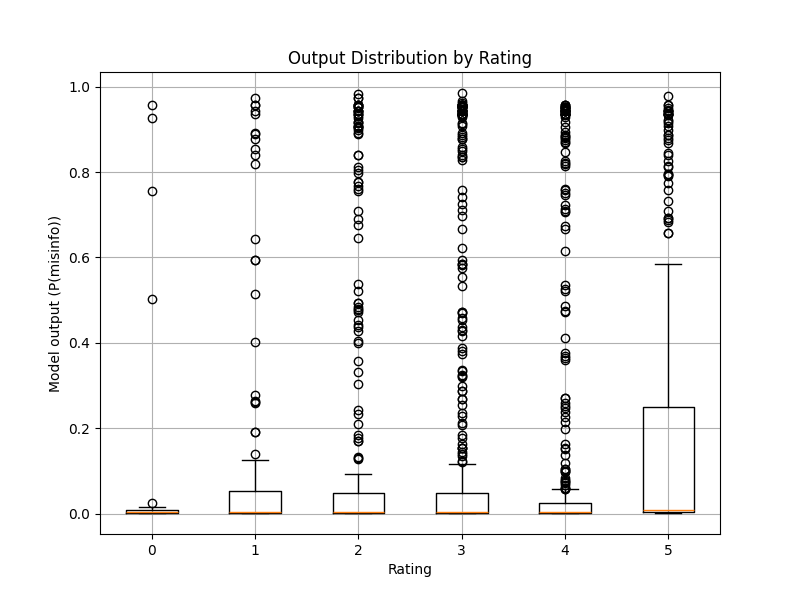

In [197]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Path to your fully fine‑tuned checkpoint
full_checkpoint_path = '/content/drive/MyDrive/Medical_Misinformation_Team/models/verifier/full-checkpoint'


tokenizer = AutoTokenizer.from_pretrained(full_checkpoint_path)
model     = AutoModelForSequenceClassification.from_pretrained(full_checkpoint_path, num_labels=2)

create_boxplot(model, tokenizer, fh_df, "fakehealth_boxplot.png")

from IPython.display import Image, display
display(Image("fakehealth_boxplot.png"))


##### Analysis:

 the weighted loss setup successfully broke the trivial factual baseline by boosting sensitivity to minority (misinfo) examples, especially among low-quality posts, but has also introduced overflagging of some genuinely good articles. we have traded accuracy for recall on the misinfo class, which is exactly the goal, so, we might needto finetune the probability threshold or gather more highrating factual examples to pull those false positives back down.

 Due to the time limitation, we will stick to binary classification

## Claim verification

### Import data

In [198]:
# import the data we got for claim verification Recall that helpful = factual (1) and unhelpful = misinformation (0)
xml_path = os.path.join(drive_data_dir, "misinfo-resources-2021/topics/misinfo-2021-topics.xml")
tree = ET.parse(xml_path)
root = tree.getroot()

trec_claims, trec_labels = [], []
for topic in root.findall("topic"):
    desc    = topic.findtext("description", default="").strip()
    stance  = topic.findtext("stance",     default="").strip().lower()
    if not desc:
        continue
    trec_claims.append(desc)

    trec_labels.append(1 if stance == "helpful" else 0)

print(f"Loaded {len(trec_claims)} TREC‑2021 claims")
for i in range(2):
    print(f"  • {trec_claims[i]} → {trec_labels[i]}")


Loaded 50 TREC‑2021 claims
  • Will wearing an ankle brace help heal achilles tendonitis? → 0
  • Is a tepid sponge bath a good way to reduce fever in children? → 0


### Read all CoAID CSVs into a DataFrame

In [199]:
coaid_frames = []
for root, _, files in os.walk(coaid_dir):
    for fname in files:
        if fname.lower().endswith(".csv"):
            path = os.path.join(root, fname)
            df = pd.read_csv(path)
            # pick the first text-like column
            for col in ["text","claim","content","title"]:
                if col in df.columns:
                    df = df[[col]].dropna().rename(columns={col:"text"})
                    df["label"] = 0 if "fake" in fname.lower() else 1
                    coaid_frames.append(df); break

coaid_df = pd.concat(coaid_frames, ignore_index=True).drop_duplicates("text").reset_index(drop=True)
print(f"→ Loaded CoAID: {len(coaid_df)} examples; label distribution:\n{coaid_df.label.value_counts()}\n")


→ Loaded CoAID: 3565 examples; label distribution:
label
1    3205
0     360
Name: count, dtype: int64



### Load FakeHealth (HealthStory) for Evaluation

In [200]:
assert os.path.isdir(fakehealth_content_dir) and os.path.isfile(fakehealth_reviews_file), \
    f"Place FakeHealth under {fakehealth_content_dir} & {fakehealth_reviews_file}"

# Load JSON content files
texts, ids = [], []
for fn in sorted(os.listdir(fakehealth_content_dir)):
    if fn.endswith(".json"):
        with open(os.path.join(fakehealth_content_dir, fn)) as f:
            doc = json.load(f)
        txt = doc.get("text") or " ".join(filter(None, [doc.get("title"), doc.get("content")]))
        texts.append(txt); ids.append(fn.split(".")[0])
# Load ratings
with open(fakehealth_reviews_file) as f:
    reviews = json.load(f)
rating_map = {str(r["news_id"]): r["rating"] for r in reviews}

# Build FakeHealth DataFrame
fakeh_df = pd.DataFrame({"news_id":ids,"text":texts})
fakeh_df["rating"] = fakeh_df.news_id.map(rating_map)
fakeh_df = fakeh_df.dropna(subset=["rating"]).reset_index(drop=True)
fakeh_df["label"] = (fakeh_df["rating"]>=3).astype(int)
print(f"→ Loaded FakeHealth: {len(fakeh_df)} examples; label distribution:\n{fakeh_df.label.value_counts()}\n")

→ Loaded FakeHealth: 1638 examples; label distribution:
label
1    1178
0     460
Name: count, dtype: int64



### Load TREC-2021 Health Misinformation (XML)

In [201]:
trec_xml = os.path.join(drive_data_dir, "misinfo-resources-2021/topics/misinfo-2021-topics.xml")

tree = ET.parse(trec_xml)
root = tree.getroot()
trec_claims, trec_labels = [], []

for topic in root.findall("topic"):
    desc = topic.findtext("description", "").strip()
    stance = topic.findtext("stance", "").strip().lower()
    if desc:
        trec_claims.append(desc)
        trec_labels.append(1 if stance=="helpful" else 0)

print(f"→ Loaded TREC‑2021: {len(trec_claims)} claims; distribution: {pd.Series(trec_labels).value_counts().to_dict()}\n")

→ Loaded TREC‑2021: 50 claims; distribution: {0: 25, 1: 25}



### Combine CoAID + TREC for Training; FakeHealth for Eval

We are trying to give the ability to the model to generalized context.
This single and unified model will have enough context to catch both COVID specific and general rumor misinformation—rather than training two narrow models and hoping they both hold up in the wild. We can use more data for this, but we stopped here for time sake.

In [202]:
train_texts = coaid_df.text.tolist() + trec_claims
train_labels= coaid_df.label.tolist()+ trec_labels
eval_texts  = fakeh_df.text.tolist()
eval_labels = fakeh_df.label.tolist()

print(f"Training on {len(train_texts)} samples  (CoAID + TREC)")
print(f"Evaluating on {len(eval_texts)} samples (FakeHealth)\n")

Training on 3615 samples  (CoAID + TREC)
Evaluating on 1638 samples (FakeHealth)



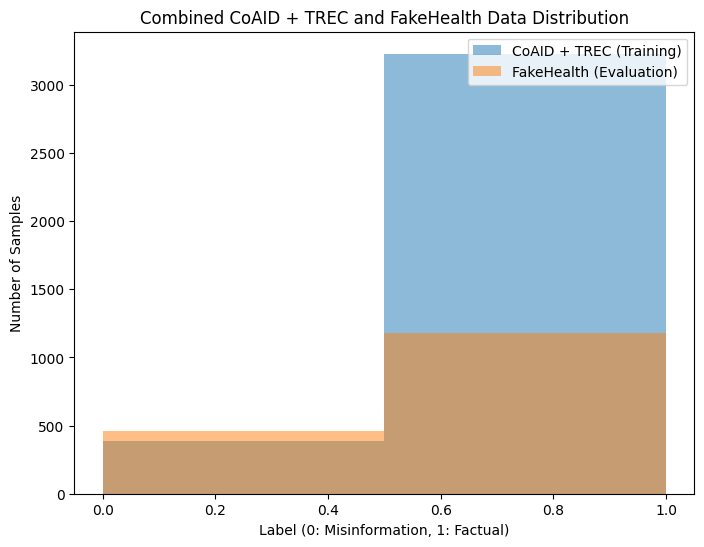

In [203]:
plt.figure(figsize=(8, 6))
plt.hist(train_labels, bins=2, alpha=0.5, label='CoAID + TREC (Training)')
plt.hist(eval_labels, bins=2, alpha=0.5, label='FakeHealth (Evaluation)')
plt.xlabel('Label (0: Misinformation, 1: Factual)')
plt.ylabel('Number of Samples')
plt.title('Combined CoAID + TREC and FakeHealth Data Distribution')
plt.legend(loc='upper right')
plt.show()


### Tokenization - Datasets

In [204]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_batch(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

train_ds = Dataset.from_dict({"text":train_texts, "label":train_labels})
eval_ds  = Dataset.from_dict({"text":eval_texts,  "label":eval_labels})

train_ds = train_ds.map(tokenize_batch, batched=True)
eval_ds  = eval_ds.map(tokenize_batch,  batched=True)

train_ds.set_format(type="torch", columns=["input_ids","attention_mask","label"])
eval_ds.set_format(type="torch",  columns=["input_ids","attention_mask","label"])

Map:   0%|          | 0/3615 [00:00<?, ? examples/s]

Map:   0%|          | 0/1638 [00:00<?, ? examples/s]

### LoRA-FineTuning BERT (SEQ_CLS)

In [205]:
#  Load & wrap your base model with LoRA as before
base = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=2
)
peft_cfg = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1
)
model = get_peft_model(base, peft_cfg)

# class weights from your train_ds labels
labels = np.array(train_ds["label"])
counts = np.bincount(labels)
total  = len(labels)
# inverse frequency: total/count → bigger weight for smaller class
weights = total / (2.0 * counts)
class_weights = torch.tensor(weights, dtype=torch.float)

# Subclass Trainer to plug in a weighted loss
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits  = outputs.logits
        loss_fct = CrossEntropyLoss(weight=class_weights.to(logits.device))
        loss = loss_fct(
            logits.view(-1, model.config.num_labels),
            labels.view(-1),
        )
        return (loss, outputs) if return_outputs else loss

def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        p.label_ids, preds, average="binary", pos_label=0
    )
    acc = accuracy_score(p.label_ids, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

training_args = TrainingArguments(
    output_dir="lora_healthmisinfo",
    eval_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=50,
    logging_strategy="steps",
    logging_steps=50,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.save_model("best_lora_healthmisinfo")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-205-acceb6afdf48>:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


#### FakeHealth evaluation

In [206]:
preds_fh = trainer.predict(eval_ds).predictions.argmax(axis=1)
print("=== FakeHealth Evaluation ===")
print(classification_report(eval_labels, preds_fh, target_names=["misinfo","factual"], digits=3))
trec_ds = Dataset.from_dict({"text":trec_claims, "label":trec_labels})
trec_ds = trec_ds.map(tokenize_batch, batched=True)
trec_ds.set_format(type="torch", columns=["input_ids","attention_mask","label"])
preds_trec = trainer.predict(trec_ds).predictions.argmax(axis=1)
print("=== TREC‑2021 Evaluation ===")
print(classification_report(trec_labels, preds_trec, target_names=["misinfo","factual"], digits=3))

=== FakeHealth Evaluation ===
              precision    recall  f1-score   support

     misinfo      0.232     0.091     0.131       460
     factual      0.713     0.882     0.789      1178

    accuracy                          0.660      1638
   macro avg      0.473     0.487     0.460      1638
weighted avg      0.578     0.660     0.604      1638



Map:   0%|          | 0/50 [00:00<?, ? examples/s]

=== TREC‑2021 Evaluation ===
              precision    recall  f1-score   support

     misinfo      0.812     0.520     0.634        25
     factual      0.647     0.880     0.746        25

    accuracy                          0.700        50
   macro avg      0.730     0.700     0.690        50
weighted avg      0.730     0.700     0.690        50



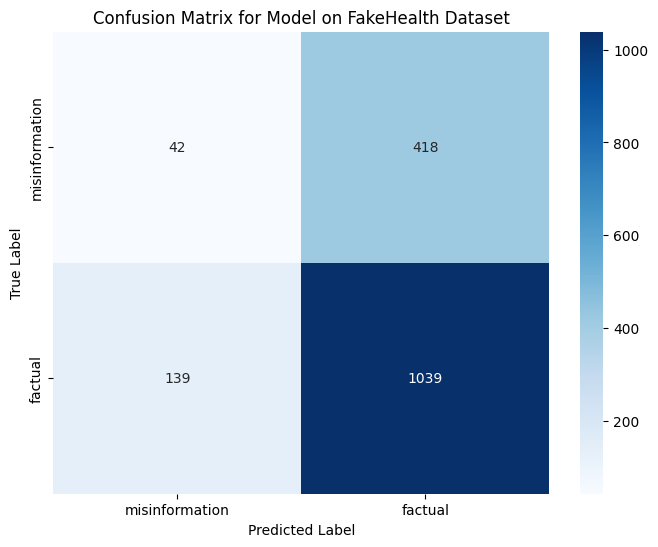

Total FakeHealth test cases: 1638


In [207]:

# Compute confusion matrix for FakeHealth evaluation
cm_fh = confusion_matrix(eval_labels, preds_fh)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_fh,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["misinformation", "factual"],
    yticklabels=["misinformation", "factual"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Model on FakeHealth Dataset")
plt.show()

# Optionally, confirm total examples:
print(f"Total FakeHealth test cases: {cm_fh.sum()}")  # should be 1638


Claim Verification dummy test

# Reddit testing

In [208]:
!pip install praw
import praw

### https://www.reddit.com/prefs/apps ###  Using this URL, create an app and use the credentials here


# Initialize PRAW with your credentials (replace with actual credentials)
reddit = praw.Reddit(client_id="Me5-91CJ2dxXV0a5bKOnTA",
                     client_secret="W4b6Pi-I9PMit548jfg6UnpNTyqK7w",
                     user_agent="misinfo-detector-script")

subreddit = reddit.subreddit("Health")
posts = []
for submission in subreddit.hot(limit=50):
    text = submission.title
    if submission.selftext:
        text += " " + submission.selftext
    posts.append(text)

print(f"Collected {len(posts)} posts from r/Health.")


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Collected 50 posts from r/Health.


In [209]:
import re

def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\<[^\>]*\>', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

posts = [clean_text(t) for t in posts]

##### Testing full finedtune best model with reddit

In [210]:
# Tokenize posts
encodings = tokenizer(posts, padding=True, truncation=True, max_length=128, return_tensors='pt')
encodings = {k: v.to(device) for k,v in encodings.items()}
# Use the best model
eval_model = model_full.to(device)
eval_model.eval()
with torch.no_grad():
    outputs = eval_model(**encodings)
predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()

# Map predictions to labels
label_map = {0: "misinformation", 1: "factual"}
for text, pred in zip(posts, predictions):
    print(f"Claim: {text}\nPredicted label: {label_map[pred]}\n")


Claim: An American retiree spent $18,807 for cancer treatment abroad. She said medical tourism saved her money and stress.
Predicted label: misinformation

Claim: Milk samples collected from over 100 Karachi tea shops found ‘contaminated’
Predicted label: misinformation

Claim: World may be ‘post-herd immunity’ to measles, top US scientist says
Predicted label: misinformation

Claim: Trump cuts demolish agency focused on toxic chemicals and workplace hazards
Predicted label: misinformation

Claim: Stomach cancer cases are rising among younger people, but there is hope for early detection
Predicted label: factual

Claim: First case of measles reported in North Dakota since 2011; "The case involves an unvaccinated child from Williams County who is believed to have contracted the illness from an out-of-state visitor."
Predicted label: factual

Claim: I’m an oncologist. Trump’s cuts will devastate cancer research.
Predicted label: misinformation

Claim: Texas goes after toothpaste in escal

##### Testing explainability model with reddit data

In [211]:
embedder = SentenceTransformer("all-MiniLM-L6-v2", device=device)

train_texts = train_ds["text"]
corpus_emb = embedder.encode(
    train_texts,
    convert_to_tensor=True,
    device=device
)

# classify and retrieve most similar training
print("=== Reddit Evaluation with Evidence Retrieval ===\n")
for post in posts:
    # Classification with trained CoAID+TREC model
    inputs = tokenizer(
        post,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    ).to(device)
    model.eval()
    with torch.no_grad():
        logits = eval_model(**inputs).logits
    pred = int(torch.argmax(logits, dim=1))
    label = label_map[pred]

    # Retrieval of the top‑matched training example as “evidence”
    claim_emb = embedder.encode(post, convert_to_tensor=True, device=device)
    sims = util.cos_sim(claim_emb, corpus_emb)[0]
    best_idx = int(torch.argmax(sims))
    evidence_text = train_texts[best_idx]
    evidence_score = float(sims[best_idx])

    # Report
    print(f"Post: {post}")
    print(f"Predicted: {label}")
    print(f"Evidence (score {evidence_score:.2f}):\n{evidence_text}\n")


=== Reddit Evaluation with Evidence Retrieval ===

Post: An American retiree spent $18,807 for cancer treatment abroad. She said medical tourism saved her money and stress.
Predicted: misinformation
Evidence (score 0.51):
we talked to experts about why this is happening and if there s relief coming to medical centers anytime soon. according to another estimate u.s. patients who are hospitalized due to covid-19 would cost the system between 362 billion and 1.449 trillion. this depends on the incidence rate or likelihood of getting covid-19 according to a report from fair health. a health affairs study reported that it would cost an average of 163.4 billion in direct medical spending during the course of t. 

Post: Milk samples collected from over 100 Karachi tea shops found ‘contaminated’
Predicted: misinformation
Evidence (score 0.45):
hand sanitizer in food packaging with flavors can be confusing to children. getty images fda warns some hand sanitizers are being packaged in food conta

We need a larger dataset than TREC to make the explainability more effective. Our current data set cannot cover enough topics. Adding microsoft c4 curreted dataset could increase the explainability significantly.

Reddit Prediction Statistics:
  misinformation: 29 posts (58.0%)
  factual: 21 posts (42.0%)


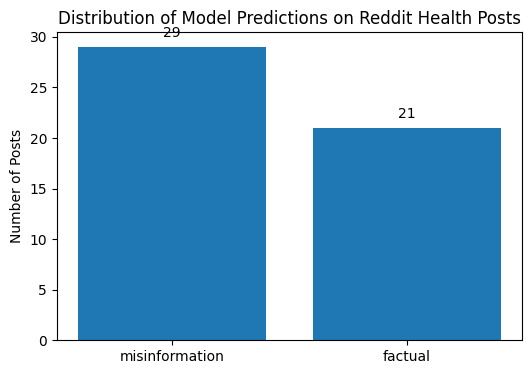

In [212]:
from collections import Counter

# counts and percentages
counts = Counter(predictions)
total = len(predictions)
stats = {label_map[k]: (v, v/total*100) for k, v in counts.items()}

print("Reddit Prediction Statistics:")
for label, (count, pct) in stats.items():
    print(f"  {label}: {count} posts ({pct:.1f}%)")

# Bar chart of the distribution
labels = list(stats.keys())
values = [stats[l][0] for l in labels]

plt.figure(figsize=(6,4))
plt.bar(labels, values)
plt.title("Distribution of Model Predictions on Reddit Health Posts")
plt.ylabel("Number of Posts")
for i, v in enumerate(values):
    plt.text(i, v + 1, str(v), ha='center')
plt.show()


Out of the total Reddit health related posts evaluated, the model classified a majority (33) as factual and the rest as misinformation. This skew means that  the subreddit's content is trustworthy based on the 50 sample.

Explainability

In [213]:
import shap
import transformers
import torch
import numpy as np
from scipy.special import logit

print(f"SHAP version: {shap.__version__}")
print(f"Transformers version: {transformers.__version__}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_lora.to(device)


SHAP version: 0.47.2
Transformers version: 4.51.3


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default

Local Token-Level Explanations with SHAP

In [214]:
import shap
import torch
import numpy as np

def f_prob(texts):
    if isinstance(texts, str) or (isinstance(texts, (list, tuple)) and all(isinstance(x, str) for x in texts)):
        enc = tokenizer(texts, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
    else:
        texts = ["".join(toks) if not isinstance(toks, str) else toks for toks in texts]
        enc = tokenizer(texts, padding="max_length", truncation=True, max_length=128, return_tensors="pt")

    enc = {k: v.to(device) for k,v in enc.items()}
    with torch.no_grad():
        logits = model_lora(**enc).logits
    probs = torch.softmax(logits, dim=-1).cpu().numpy()
    return probs

# Build masker & explainer
masker = shap.maskers.Text(tokenizer)
# output_names should match the outputs of f_prob
explainer = shap.Explainer(f_prob, masker, output_names=["misinfo","factual"])

example_text = "COVID-19 vaccines completely eliminate the risk of infection."

shap_values = explainer("COVID-19 vaccines completely eliminate the risk of infection.")

# 5) Plot token contributions for the “misinfo” channel
print(f"Claim: {example_text}\n")
shap.plots.text(shap_values)

Claim: COVID-19 vaccines completely eliminate the risk of infection.



##### Analysis

The SHAP plot gives a visualization of the contribution of each token in the input text to the model's prediction.

Each word or sub-word token is displayed, and its color indicates its impact on the model's prediction.  Blue tokens push the model towards predicting misinformation, while red tokens push it towards factual. The intensity of the color represents the magnitude of the effect.

These tokens seem to slightly lean towards the factual prediction. This makes sense because vaccines are a real concept related to COVID-19.  However, the color is not strongly red, indicating this part alone doesn't definitively point to a factual statement

This phrase strongly leans towards misinformation.  The model likely interprets the word "completely" as an overstatement or an indicator of potential inaccuracy in a medical context.  Vaccines reduce the risk of severe infection, hospitalization, and death, but they do not completely eliminate the risk.  The model has learned, based on its training, that such strong, absolute claims are frequently associated with misinformation.

The combination of these token contributions leads the model to predict that the statement is likely "misinformation" as there is a slightly more blue intensity than red, which is what the model learned from its training data